In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [5]:
def to_Str(df_, list):
    for i in list:
        df_[i] = df_[i].astype(str)
def AB_to_NewIntColumns(df_, list, p):
    for i in list:
        df_[i+'_'] = df_[i].apply(lambda x: x==p)
        df[i+'_'] = df[i+'_'].astype(int)
def AB_to_IntColumns(df_, list, p):
    for i in list:
        df_[i+'_'] = df_[i].apply(lambda x: x==p)
        df_[i+'_'] = df_[i+'_'].astype(int)
        df_[i] = df_[i+'_']

In [6]:
def get_NaN_info(df_):
    return len(df_)-df_.count()

def set_NaN_median(df_, col1):
    df_.loc[df_[col1].isnull(), col1] = df_[col1].median()

In [7]:
def features_Stand(features_,X_):
    scaler = StandardScaler()
    X_train_scaled = X_.copy()
    X_train_scaled[features_] = scaler.fit_transform(X_train_scaled[features_])
    return X_train_scaled

In [8]:
def IQ_param_get(df_, column_):
    m = df_[column_].median()
    c = column_
    IQ=df_[c].describe()['75%']-df_[c].describe()['25%']
    
    low_border=df_[c].describe()['25%']-IQ*1.5
    
    high_border=df_[c].describe()['75%']+IQ*1.5
 
    count1 = df_[(df_[c] < low_border) | (df_[c]> high_border)][c].count()
    
    result = {
        'IQ':IQ,
        'low_border':low_border,
        'high_border':high_border,
        'count': count1,
        'median': m
    }
    return result

In [9]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [10]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


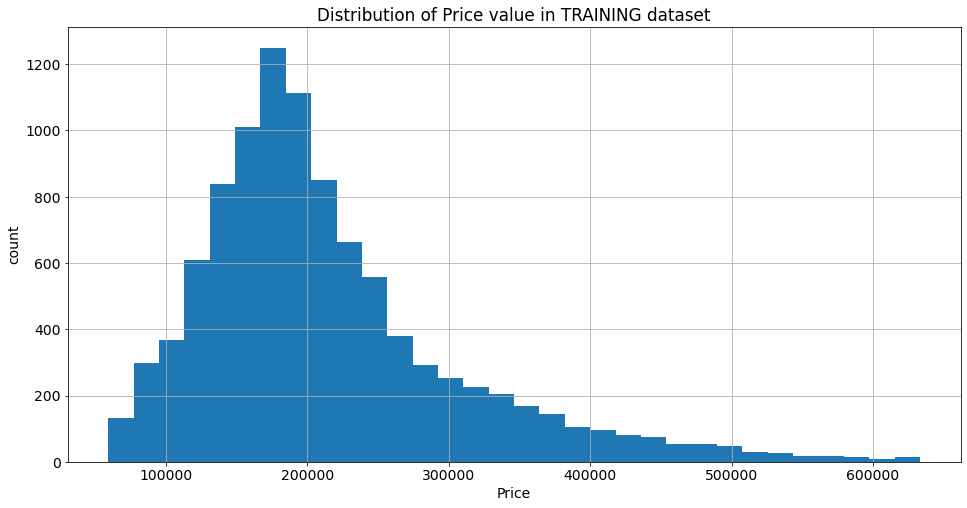

In [11]:
plt.figure(figsize = (16, 8))

train['Price'].hist(bins=32)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price value in TRAINING dataset')
plt.show()

In [12]:
train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [13]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [14]:
test['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [15]:
to_Str(train,['Id'])
to_Str(test,['Id'])

In [16]:
set_NaN_median(test,'LifeSquare')
set_NaN_median(test,'Healthcare_1')

In [17]:

set_NaN_median(train,'LifeSquare')
set_NaN_median(train,'Healthcare_1')

In [18]:
KSmode = train['KitchenSquare'].mode()[0]
LSmode = train['LifeSquare'].mode()[0]
Rmode = train['Rooms'].mode()[0]
print('MODE values in train are:')
print('KitchenSquare:',KSmode,'LifeSquare:',LSmode,'Rooms:',Rmode)

train.loc[train['Rooms']==0, 'Rooms'] = Rmode
train.loc[train['KitchenSquare']==0, 'KitchenSquare'] = KSmode

MODE values in train are:
KitchenSquare: 1.0 LifeSquare: 32.781260192155735 Rooms: 2.0


In [19]:
train['Rooms'].value_counts()

2.0     3888
1.0     3705
3.0     2235
4.0      150
5.0       18
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [20]:
KSmode = test['KitchenSquare'].mode()[0]
LSmode = test['LifeSquare'].mode()[0]
Rmode = test['Rooms'].mode()[0]
print('MODE values in test are:')
print('KitchenSquare:',KSmode,'LifeSquare:',LSmode,'Rooms:',Rmode)

test.loc[test['Rooms']==0, 'Rooms'] = Rmode
test.loc[test['KitchenSquare']==0, 'KitchenSquare'] = KSmode

MODE values in test are:
KitchenSquare: 1.0 LifeSquare: 32.92508663208161 Rooms: 2.0


In [21]:

test['Rooms'].value_counts()

2.0     2032
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [22]:
AB_to_IntColumns(test,['Ecology_2','Ecology_3','Shops_2'],'A')
AB_to_IntColumns(train,['Ecology_2','Ecology_3','Shops_2'],'A')

In [23]:
test['Shops_2'].value_counts()

0    4588
1     412
Name: Shops_2, dtype: int64

In [24]:

train = train.drop(['Ecology_2_'],axis=1)
train = train.drop(['Ecology_3_'],axis=1)
train = train.drop(['Shops_2_'],axis=1)
test = test.drop(['Ecology_2_'],axis=1)
test = test.drop(['Ecology_3_'],axis=1)
test = test.drop(['Shops_2_'],axis=1)

test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,51.279200,1.910800,56.449500,35.485549,6.043800,8.632000,12.601000,1984.392600,0.119874,0.009600,0.029800,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.082400
std,44.179466,0.837725,19.092787,15.915345,9.912837,5.483228,6.789213,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001
min,0.000000,1.000000,1.378543,0.333490,1.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,21.000000,1.000000,41.906231,25.850152,1.000000,4.000000,9.000000,1973.000000,0.019509,0.000000,0.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,0.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,0.000000,0.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,0.000000
75%,77.000000,2.000000,66.285129,41.769526,9.000000,12.000000,17.000000,2000.000000,0.195781,0.000000,0.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,0.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


In [25]:
def IQ_processing(df_, list_):
    for i in list_:
        c = i
        IQP = IQ_param_get(df_,c)
        print(c,IQP)
        df_[(df_[c] < IQP['low_border']) | (df_[c]> IQP['high_border'])]
        df_.loc[df_[c] > IQP['high_border'], c] = IQP['median']
        df_.loc[df_[c] < IQP['low_border'], c] = IQP['median']
        print('count after procesing:',df_[(df_[c] < IQP['low_border']) | (df_[c]> IQP['high_border'])][c].count())

In [26]:
mode = train['HouseYear'].mode()[0]
print('mode', mode)
train.loc[train['HouseYear'] > 2019, 'HouseYear'] = mode
train['HouseYear'] = train['HouseYear'].astype(int)
train['HouseYear'].nlargest()

mode 1977


29     2019
142    2019
151    2019
165    2019
190    2019
Name: HouseYear, dtype: int32

In [27]:
test.loc[test['HouseYear'] > 2019, 'HouseYear'] = test['HouseYear'].mode()[0]
test['HouseYear'] = test['HouseYear'].astype(int)
test['HouseYear'].nlargest()

169    2019
212    2019
316    2019
392    2019
525    2019
Name: HouseYear, dtype: int32

In [28]:

def draw_feature(fname):
    t = fname
    plt.figure(figsize = (12, 6))

    train[t].hist(bins=16)
    test[t].hist(bins=16)
    plt.ylabel('count')
    plt.xlabel(t)

    plt.title('Distribution of '+ t +' value in TRAINING and TEST dataset')
    plt.show()

In [29]:
m=train['KitchenSquare'].mean()
print('KitchenSquare mean value in TRAIN is:',m)
train.loc[train['KitchenSquare'] < 4, 'KitchenSquare'] = m

m=test['KitchenSquare'].mean()
print('KitchenSquare mean value in TEST is:',m)
test.loc[test['KitchenSquare'] < 4, 'KitchenSquare'] = m

KitchenSquare mean value in TRAIN is: 6.343
KitchenSquare mean value in TEST is: 6.0438


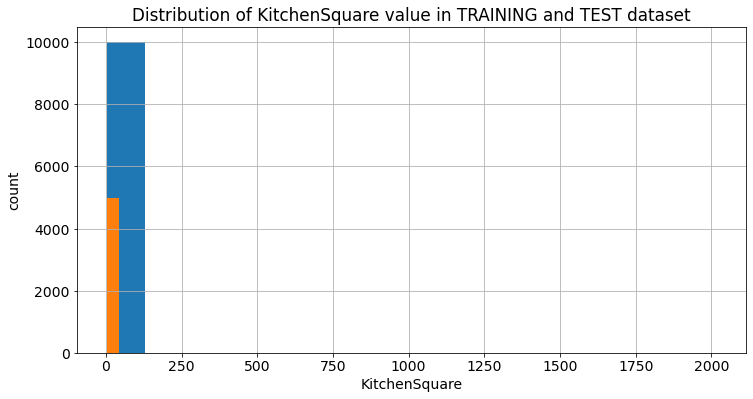

In [30]:
draw_feature('KitchenSquare')


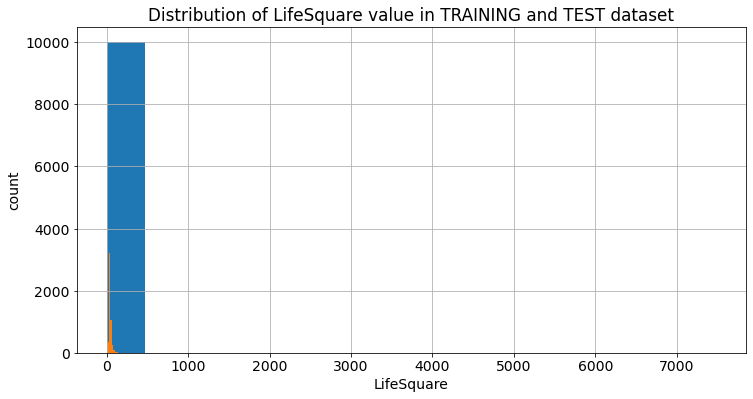

In [31]:
draw_feature('LifeSquare')


In [32]:
train.loc[train['LifeSquare'] < 15, 'LifeSquare'] = train['Square'] - train['KitchenSquare']
test.loc[test['LifeSquare'] < 15, 'LifeSquare'] = test['Square'] - test['KitchenSquare']

In [33]:

def HouseFloor_processing(df_):
    Fmode = df_['Floor'].mode()[0]
    HFmode = df_['HouseFloor'].mode()[0]
    print('Floor:',Fmode,'HouseFloor:',HFmode)

    df_.loc[(df_['HouseFloor']==0) & (HFmode >= df_['Floor']),'HouseFloor'] = HFmode #if HFmode > df_['Floor'] else df_['Floor']
    df_.loc[(df_['HouseFloor']==0) & (HFmode < df_['Floor']),'HouseFloor'] = df_['Floor']

    df_.loc[(df_['HouseFloor'] < df_['Floor'])&(HFmode >= df_['Floor']), 'HouseFloor'] = HFmode
    df_.loc[(df_['HouseFloor'] < df_['Floor'])&(HFmode < df_['Floor']), 'HouseFloor'] = df_['Floor']

In [34]:
print('Processing HouseFloor in TRAIN')
HouseFloor_processing(train)
print('Processing HouseFloor in TEST')
HouseFloor_processing(test)

Processing HouseFloor in TRAIN
Floor: 4 HouseFloor: 17.0
Processing HouseFloor in TEST
Floor: 4 HouseFloor: 17.0


In [35]:
train[train['HouseFloor'] < train['Floor']]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [36]:
df = train
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.892100,56.315775,37.277486,8.038877,8.526700,14.681600,1984.782100,0.118858,0.009700,0.027500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.082500,214138.857399
std,43.587592,0.837811,21.058732,76.544773,28.337156,5.241148,5.634714,18.349177,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,0.000000,1.000000,1.136859,-5.206141,4.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,27.624600,6.343000,4.000000,10.000000,1974.000000,0.017647,0.000000,0.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,0.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.343000,7.000000,17.000000,1977.000000,0.075424,0.000000,0.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.000000,192269.644879
75%,75.000000,2.000000,65.900625,42.288226,9.000000,12.000000,17.000000,2001.000000,0.195781,0.000000,0.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,0.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2019.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


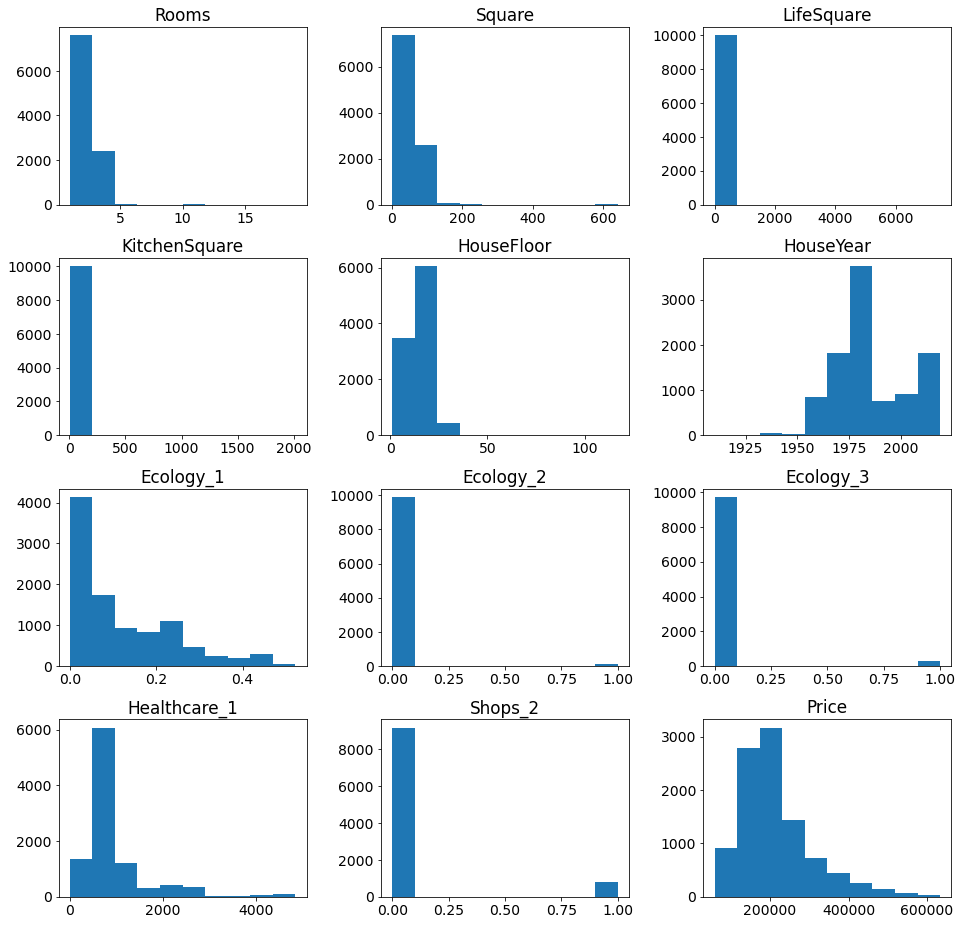

In [37]:
df_num_features = df.select_dtypes(include=['float64', 'int'])
df_num_features.hist(figsize=(16,16), bins=10, grid=False);

In [39]:

feature_names = ['Id','DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','Shops_2']

feature_names_without_id = feature_names.copy()
feature_names_without_id.remove('Id')
Xtrain = train[feature_names]
Xtest = test[feature_names]

In [40]:
feature_names_for_stand = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']

In [41]:
X2train = features_Stand(feature_names_for_stand, Xtrain)
X2train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000
mean,-2.877920e-16,-1.012079e-16,-2.330580e-16,-2.341183e-17,-2.220793e-16,-3.204104e-17,2.522427e-16,5.111445e-15,4.450190e-17,0.009700,0.027500,4.351408e-16,7.950307e-17,2.153278e-17,4.805573e-16,6.643130e-16,-3.941292e-18,0.082500
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.098015,0.163543,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.275139
min,-1.156369e+00,-1.064851e+00,-2.620370e+00,-5.550445e-01,-1.425365e-01,-1.436150e+00,-2.428213e+00,-4.075705e+00,-9.986406e-01,0.000000,0.000000,-1.408132e+00,-1.293905e+00,-3.373466e-01,-1.374664e+00,-8.834798e-01,-8.804019e-01,0.000000
25%,-6.974994e-01,-1.064851e+00,-6.905269e-01,-1.261140e-01,-5.984940e-02,-8.637280e-01,-8.308912e-01,-5.876361e-01,-8.503701e-01,0.000000,0.000000,-1.065895e+00,-9.454794e-01,-3.373466e-01,-2.629952e-01,-8.834798e-01,-6.723330e-01,0.000000
50%,-3.304041e-01,1.287944e-01,-1.805738e-01,-5.874276e-02,-5.984940e-02,-2.913057e-01,4.114701e-01,-4.241329e-01,-3.649310e-01,0.000000,0.000000,1.785334e-02,-1.676170e-02,-2.534212e-01,-1.692400e-01,-2.139233e-01,-2.561952e-01,0.000000
75%,5.643907e-01,1.287944e-01,4.551713e-01,6.546482e-02,3.391911e-02,6.627314e-01,4.114701e-01,8.838931e-01,6.463114e-01,0.000000,0.000000,6.452869e-01,4.679386e-01,-1.275331e-01,-4.869764e-02,4.556332e-01,3.680115e-01,0.000000
max,3.638814e+00,2.042077e+01,2.776894e+01,9.724618e+01,7.079262e+01,6.386954e+00,1.815949e+01,1.864913e+00,3.386085e+00,1.000000,1.000000,2.812784e+00,3.427056e+00,5.579395e+00,5.119891e+00,3.133859e+00,3.905183e+00,1.000000


In [42]:
X2test = features_Stand(feature_names_for_stand, Xtest)
X2test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,-0.164781,-1.087339,-1.026766,-1.107306,-0.276352,-0.662450,-0.958854,-0.773283,-0.697594,0,0,-0.053267,-0.255550,-0.346275,0.008615,-0.215841,-0.678852,0
1,5925,0.242689,-1.087339,-0.731008,0.370018,0.256509,-0.297665,0.416143,1.765578,-0.397445,0,0,-1.308227,-1.186699,-0.304366,-0.168811,-0.891612,-0.888194,1
2,960,-0.549613,0.106489,0.157886,-0.236863,0.149936,1.891046,0.759892,-0.395155,0.762360,0,0,-0.908921,-0.873004,-0.346275,-0.168811,-0.891612,-0.678852,0
3,3848,-0.640162,1.300318,-0.356373,-0.175896,-0.169780,-1.209627,-2.161976,-1.043375,-0.881250,0,0,-1.308227,-1.224948,-0.346275,-0.168811,-0.891612,-0.888194,0
4,746,0.514336,-1.087339,-0.136843,-0.236863,-0.165112,-0.115272,0.416143,-0.395155,1.579283,0,0,0.574212,0.573268,-0.178640,-0.051397,-0.891612,0.367855,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,-0.504339,0.106489,-0.695200,-0.399558,-0.276352,-0.480057,0.416143,-1.205429,-0.418245,0,0,0.346038,0.176866,-0.178640,-0.168811,-0.215841,-0.469511,0
4996,16138,-0.300604,1.300318,1.951122,3.639683,0.256509,2.255831,2.134889,1.819596,-0.492437,0,0,-0.566660,-0.650711,-0.262458,-0.664558,-0.891612,0.577196,0
4997,3912,1.125540,-1.087339,-1.193909,-1.113029,-0.276352,-1.209627,-1.646353,-0.989356,-0.676182,0,0,0.174907,0.279692,-0.304366,-0.018782,0.459930,0.158513,0
4998,5722,-0.934446,-1.087339,-0.933134,-0.988859,0.149936,-0.115272,-0.099481,-0.773283,-0.256828,0,0,0.460125,0.638094,-0.136731,-0.168811,-0.891612,1.414561,0


In [43]:
y = train['Price']


In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X2train.drop(['Id'],axis=1), y, test_size=0.3, random_state=42)

In [45]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     7000 non-null   float64
 1   Rooms          7000 non-null   float64
 2   Square         7000 non-null   float64
 3   LifeSquare     7000 non-null   float64
 4   KitchenSquare  7000 non-null   float64
 5   Floor          7000 non-null   float64
 6   HouseFloor     7000 non-null   float64
 7   HouseYear      7000 non-null   float64
 8   Ecology_1      7000 non-null   float64
 9   Ecology_2      7000 non-null   int32  
 10  Ecology_3      7000 non-null   int32  
 11  Social_1       7000 non-null   float64
 12  Social_2       7000 non-null   float64
 13  Social_3       7000 non-null   float64
 14  Healthcare_1   7000 non-null   float64
 15  Helthcare_2    7000 non-null   float64
 16  Shops_1        7000 non-null   float64
 17  Shops_2        7000 non-null   int32  
dtypes: fl

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [47]:
y_train

9069    251801.837999
2603    134975.006573
7738    153924.162352
1579    313853.958464
5058    113608.081406
            ...      
5734    216640.538858
5191    241324.507250
5390    163496.966243
860     128710.472293
7270    109129.982392
Name: Price, Length: 7000, dtype: float64

R2:	0.486
MAE:	45213.978
MSE:	4298481275.776


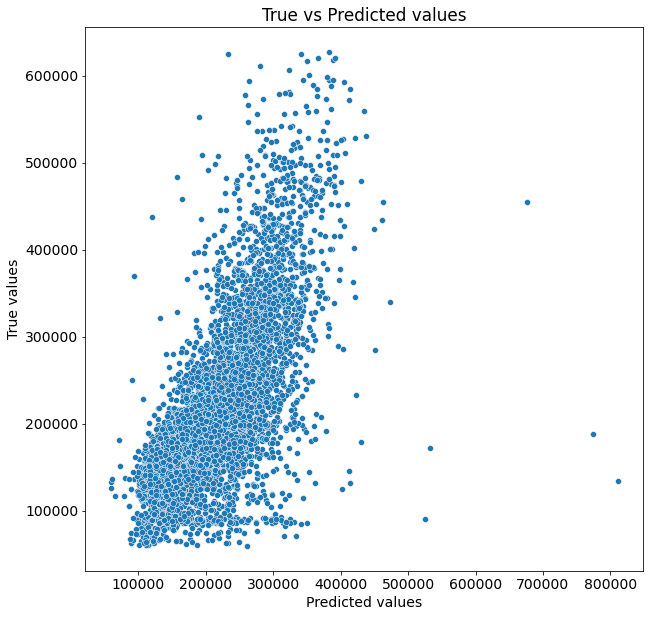

In [48]:
y_train_preds = lr.predict(X_train)
y_train_preds
evaluate_preds(y_train, y_train_preds) 

In [49]:

y_valid_preds = lr.predict(X_valid)
y_valid_preds

array([300127.07725653, 222018.64025403, 263063.82549262, ...,
       187139.17305937, 309191.20444016, 227897.56321238])

In [50]:
check_valid = pd.DataFrame({
    "y_valid": y_valid,
    "y_valid_preds": y_valid_preds.flatten(),
})
check_valid["error"] = check_valid["y_valid_preds"] - check_valid["y_valid"]
check_valid

,y_valid,y_valid_preds,error
6252,225202.099645,300127.077257,74924.977612
4684,361744.269547,222018.640254,-139725.629293
1731,275055.182201,263063.825493,-11991.356708
4742,198133.702204,174315.434916,-23818.267288
4521,221299.460377,148695.785129,-72603.675248
...,...,...,...
8014,231115.381062,253567.406664,22452.025602
1074,150822.681564,173480.883246,22658.201682
3063,196519.976169,187139.173059,-9380.803110
6487,380765.543594,309191.204440,-71574.339154


R2:	0.488
MAE:	46962.721
MSE:	4710190446.179


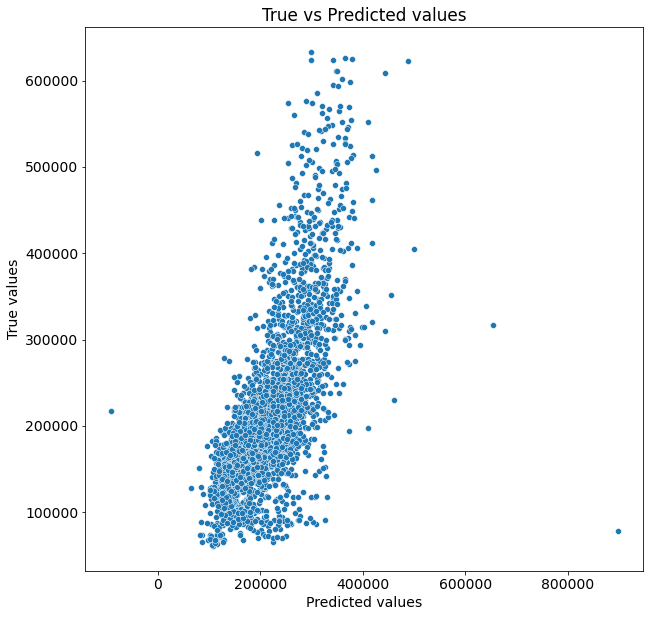

In [51]:
evaluate_preds(y_valid, y_valid_preds)


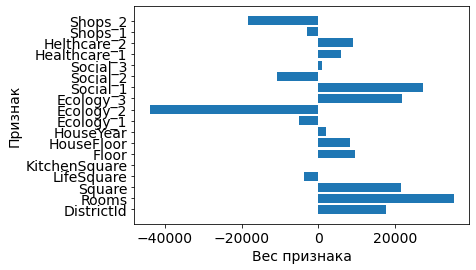

In [52]:

plt.barh(feature_names_without_id, lr.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

In [53]:

y_test_preds = lr.predict(X2test.drop(['Id'], axis=1))
y_test_preds

array([145177.00242302, 122674.18932365, 210833.12709516, ...,
       156667.60509207, 134001.6205794 , 252454.86223102])

In [54]:
X2test["Price"] = lr.predict(X2test.drop(['Id'], axis=1))

In [55]:
def SAVE_TO_FILE(df_, modelName):
    df_.loc[:, ['Id', 'Price']].to_csv('mmingalov_kaggle_predictions(' + modelName + ').csv', index=False)

In [56]:
SAVE_TO_FILE(X2test,'lr')

In [57]:
rs = 22
X_train, X_valid, y_train, y_valid = train_test_split(X2train.drop(['Id'],axis=1), y, test_size=0.10, random_state=rs)

In [58]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=18, random_state=rs, max_features=7)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=18, max_features=7, n_estimators=1000,
                      random_state=22)

R2:	0.955
MAE:	12543.817
MSE:	387827253.157


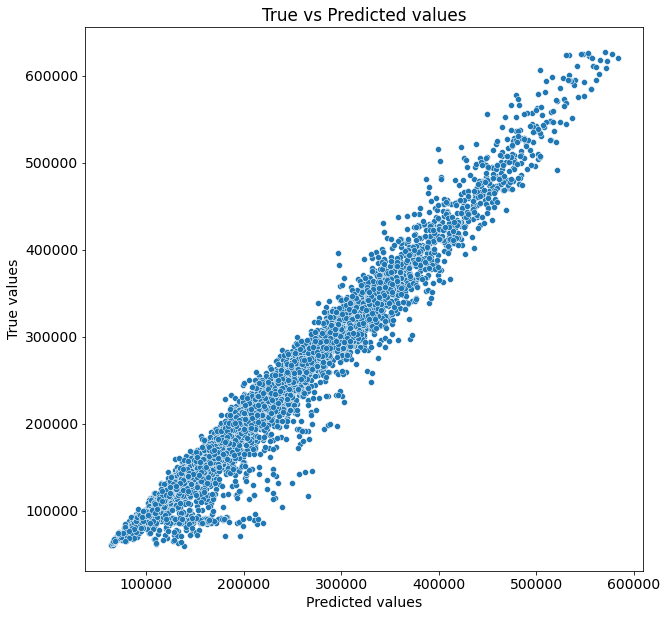

array([246668.75713838, 155696.58239854, 259459.97178052, ...,
       189587.20442168, 219643.95919096, 213926.52703117])

In [59]:
y_train_preds = rf.predict(X_train)
evaluate_preds(y_train, y_train_preds)
y_train_preds

R2:	0.721
MAE:	28986.832
MSE:	2441213622.359


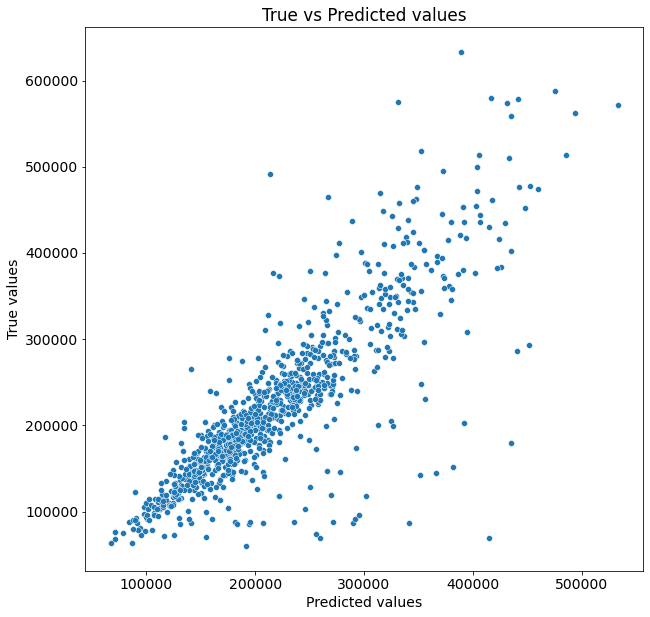

In [60]:
y_valid_preds = rf.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

In [61]:
df = X2test.drop(['Price'],axis=1).drop(['Id'],axis=1)

In [62]:
X2test['Price'] = rf.predict(df)


In [63]:
SAVE_TO_FILE(X2test,'rf++')
